#### Session Connection

* Connects to snowflake session
* Section delineates creating our required warehouse, database, schema and stage

In [1]:
from snowflake.snowpark import Session
import configparser

In [2]:
# example connection parameters:
connection_parameters = {
    "account": "<your snowflake account identifier>",
    "user": "<your snowflake username>",
    "password": "<your snowflake password>",
    "role": "<your snowflake role>",
    "warehouse": "<your snowflake warehouse>",  # optional
    "database": "<your snowflake database>",  # optional
    "schema": "<your snowflake schema>" # optional
  }

# it is best practice to not use/save your credentials in a jupyter notebook
# In this case I'm loading my credentials as a dictionary
snowflake_credentials_file = '../snowflake_creds.config'
config = configparser.ConfigParser()
config.read(snowflake_credentials_file)
connection_parameters = dict(config['default'])

In [3]:
session = Session.builder.configs(connection_parameters).create()

In [4]:
session.sql("CREATE WAREHOUSE IF NOT EXISTS COMPUTE_WH WITH WAREHOUSE_SIZE='X-SMALL'").collect()
session.sql("CREATE DATABASE IF NOT EXISTS SNOWPARK_DEFINITIVE_GUIDE").collect()
session.sql("CREATE SCHEMA IF NOT EXISTS SNOWPARK_DEFINITIVE_GUIDE.MY_SCHEMA").collect()
session.sql("CREATE STAGE IF NOT EXISTS SNOWPARK_DEFINITIVE_GUIDE.MY_SCHEMA.MY_STAGE").collect()

session.use_database("SNOWPARK_DEFINITIVE_GUIDE")
session.use_schema("MY_SCHEMA")

session.sql('select current_warehouse(), current_database(), current_schema(), current_user(), current_role()').collect()

[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='SNOWPARK_DEFINITIVE_GUIDE', CURRENT_SCHEMA()='MY_SCHEMA', CURRENT_USER()='PRESTONB', CURRENT_ROLE()='ACCOUNTADMIN')]

### Loading CSV Format

* This section explains loading required CSV files into the Snowflake Instance
* Steps involved uploading the CSV files to Snowflake stage, defining schema and loading into table

##### Uploading Files To Stage Location

In [5]:
session.file.put('../datasets/purchase_history.csv', 'MY_STAGE')
session.file.put('../datasets/marketing_additional.csv', 'MY_STAGE')

[PutResult(source='marketing_additional.csv', target='marketing_additional.csv.gz', source_size=23683, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message='')]

##### Defining Schema and Loading Datasets

In [6]:
import snowflake.snowpark.types as T

purchase_history_schema = T.StructType([T.StructField("ID", T.IntegerType()),
        T.StructField("Year_Birth", T.IntegerType()),T.StructField("Education", T.StringType()),
        T.StructField("Marital_Status", T.StringType()),T.StructField("Income", T.IntegerType()),
        T.StructField("Kidhome", T.IntegerType()),T.StructField("Teenhome", T.IntegerType()),
        T.StructField("Dt_Customer", T.DateType()),T.StructField("Recency", T.IntegerType()),
        T.StructField("MntWines", T.IntegerType()),T.StructField("MntFruits", T.IntegerType()),
        T.StructField("MntMeatProducts", T.IntegerType()),T.StructField("MntFishProducts", T.IntegerType()),
        T.StructField("MntSweetProducts", T.IntegerType()),T.StructField("MntGoldProds", T.IntegerType()),
        T.StructField("NumDealsPurchases", T.IntegerType()),T.StructField("NumWebPurchases", T.IntegerType()),
        T.StructField("NumCatalogPurchases", T.IntegerType()),T.StructField("NumStorePurchases", T.IntegerType()),
        T.StructField("NumWebVisitsMonth", T.IntegerType())
])

session.sql("TRUNCATE TABLE IF EXISTS PURCHASE_HISTORY").collect()

purchase_history = session.read\
        .option("FIELD_DELIMITER", ',')\
        .option("SKIP_HEADER", 1)\
        .option("ON_ERROR", "CONTINUE")\
        .schema(purchase_history_schema).csv("@MY_Stage/purchase_history.csv.gz")\
        .copy_into_table("PURCHASE_HISTORY")

session.table("PURCHASE_HISTORY").show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"  |"YEAR_BIRTH"  |"EDUCATION"  |"MARITAL_STATUS"  |"INCOME"  |"KIDHOME"  |"TEENHOME"  |"DT_CUSTOMER"  |"RECENCY"  |"MNTWINES"  |"MNTFRUITS"  |"MNTMEATPRODUCTS"  |"MNTFISHPRODUCTS"  |"MNTSWEETPRODUCTS"  |"MNTGOLDPRODS"  |"NUMDEALSPURCHASES"  |"NUMWEBPURCHASES"  |"NUMCATALOGPURCHASES"  |"NUMSTOREPURCHASES"  |"NUMWEBVISITSMONTH"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
import snowflake.snowpark.types as T

marketing_additional_schema = T.StructType([T.StructField("ID", T.IntegerType()),
        T.StructField("Year_Birth", T.IntegerType()),T.StructField("Education", T.StringType()),
        T.StructField("Marital_Status", T.StringType()),T.StructField("Income", T.IntegerType()),
        T.StructField("Kidhome", T.IntegerType()),T.StructField("Teenhome", T.IntegerType()),
        T.StructField("Dt_Customer", T.DateType()),T.StructField("Recency", T.IntegerType()),
        T.StructField("MntWines", T.IntegerType()),T.StructField("MntFruits", T.IntegerType()),
        T.StructField("MntMeatProducts", T.IntegerType()),T.StructField("MntFishProducts", T.IntegerType()),
        T.StructField("MntSweetProducts", T.IntegerType()),T.StructField("MntGoldProds", T.IntegerType()),
        T.StructField("NumDealsPurchases", T.IntegerType()),T.StructField("NumWebPurchases", T.IntegerType()),
        T.StructField("NumCatalogPurchases", T.IntegerType()),T.StructField("NumStorePurchases", T.IntegerType()),
        T.StructField("NumWebVisitsMonth", T.IntegerType()),T.StructField("AcceptedCmp3", T.IntegerType()),
        T.StructField("AcceptedCmp4", T.IntegerType()),T.StructField("AcceptedCmp5", T.IntegerType()),
        T.StructField("AcceptedCmp1", T.IntegerType()),T.StructField("AcceptedCmp2", T.IntegerType()),
        T.StructField("Complain", T.IntegerType()),T.StructField("Z_CostContact", T.IntegerType()),
        T.StructField("Z_Revenue", T.IntegerType()),T.StructField("Response", T.DecimalType())
])

session.sql("TRUNCATE TABLE IF EXISTS MARKETING_ADDITIONAL").collect()

marketing_additional = session.read\
        .option("FIELD_DELIMITER", ',')\
        .option("SKIP_HEADER", 1)\
        .option("ON_ERROR", "CONTINUE")\
        .schema(marketing_additional_schema).csv("@MY_Stage/marketing_additional.csv.gz")\
        .copy_into_table("MARKETING_ADDITIONAL")

session.table("MARKETING_ADDITIONAL").show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"   |"YEAR_BIRTH"  |"EDUCATION"  |"MARITAL_STATUS"  |"INCOME"  |"KIDHOME"  |"TEENHOME"  |"DT_CUSTOMER"  |"RECENCY"  |"MNTWINES"  |"MNTFRUITS"  |"MNTMEATPRODUCTS"  |"MNTFISHPRODUCTS"  |"MNTSWEETPRODUCTS"  |"MNTGOLDPRODS"  |"NUMDEALSPURCHASES"  |"NUMWEBPURCHASES"  |"NUMCATALOGPURCHASES"  |"NUMSTOREPURCHASES"  |"NUMWEBVISITSMONTH"  |"ACCEPTEDCMP3"  |"ACCEPTEDCMP4"  |"ACCEPTEDCMP5"  |"ACCEPTEDCMP1"  |"ACCEPTEDCMP2"  |"COMPLAIN"  |"Z_COSTCONTACT"  |"Z_REVENUE"  |"RESPONSE"  |
----------------------------------------

### Loading JSON Format

* This section explains loading required JSON file into the Snowflake Instance
* Steps involved uploading the JSON file to Snowflake stage, defining schema and loading into table

In [8]:
session.file.put('../datasets/campaign_info.json', 'MY_STAGE')

df_from_json = session.read.json("@My_Stage/campaign_info.json.gz")
df_from_json.write.save_as_table("CAMPAIGN_INFO_TEMP", mode = "overwrite")

df_from_json.show()

------------------------
|"$1"                  |
------------------------
|{                     |
|  "AcceptedCmp1": 0,  |
|  "AcceptedCmp2": 0,  |
|  "AcceptedCmp3": 0,  |
|  "AcceptedCmp4": 0,  |
|  "AcceptedCmp5": 0,  |
|  "ID": 5524,         |
|  "Response": 1       |
|}                     |
|{                     |
|  "AcceptedCmp1": 0,  |
|  "AcceptedCmp2": 0,  |
|  "AcceptedCmp3": 0,  |
|  "AcceptedCmp4": 0,  |
|  "AcceptedCmp5": 0,  |
|  "ID": 2174,         |
|  "Response": 0       |
|}                     |
|{                     |
|  "AcceptedCmp1": 0,  |
|  "AcceptedCmp2": 0,  |
|  "AcceptedCmp3": 0,  |
|  "AcceptedCmp4": 0,  |
|  "AcceptedCmp5": 0,  |
|  "ID": 4141,         |
|  "Response": 0       |
|}                     |
|{                     |
|  "AcceptedCmp1": 0,  |
|  "AcceptedCmp2": 0,  |
|  "AcceptedCmp3": 0,  |
|  "AcceptedCmp4": 0,  |
|  "AcceptedCmp5": 0,  |
|  "ID": 6182,         |
|  "Response": 0       |
|}                     |
|{                     |


In [9]:
from snowflake.snowpark.functions import col

df_flatten = df_from_json.select(col("$1")["ID"].as_("ID"),\
    col("$1")["AcceptedCmp1"].as_("AcceptedCmp1"),\
    col("$1")["AcceptedCmp2"].as_("AcceptedCmp2"),\
    col("$1")["AcceptedCmp3"].as_("AcceptedCmp3"),\
    col("$1")["AcceptedCmp4"].as_("AcceptedCmp4"),\
    col("$1")["AcceptedCmp5"].as_("AcceptedCmp5"),\
    col("$1")["Response"].as_("Response"))

df_flatten.write.save_as_table("CAMPAIGN_INFO", mode="overwrite")
session.table("CAMPAIGN_INFO").show()

----------------------------------------------------------------------------------------------------------
|"ID"  |"ACCEPTEDCMP1"  |"ACCEPTEDCMP2"  |"ACCEPTEDCMP3"  |"ACCEPTEDCMP4"  |"ACCEPTEDCMP5"  |"RESPONSE"  |
----------------------------------------------------------------------------------------------------------
|5524  |0               |0               |0               |0               |0               |1           |
|2174  |0               |0               |0               |0               |0               |0           |
|4141  |0               |0               |0               |0               |0               |0           |
|6182  |0               |0               |0               |0               |0               |0           |
|5324  |0               |0               |0               |0               |0               |0           |
|7446  |0               |0               |0               |0               |0               |0           |
|965   |0               |0           

### Loading Parquet Format

* This section explains loading required parquet file into the Snowflake Instance
* Steps involved uploading the parquet file to Snowflake stage, defining schema and loading into table

In [10]:
session.file.put('../datasets/complain_info.parquet', 'MY_STAGE')

session.sql("TRUNCATE TABLE IF EXISTS COMPLAINT_INFO").collect()

df_raw = session.read.parquet("@My_Stage/complain_info.parquet")
df_raw.copy_into_table("COMPLAINT_INFO")

session.table("COMPLAINT_INFO").show()

-----------------------------------------------------
|"ID"  |"COMPLAIN"  |"Z_COSTCONTACT"  |"Z_REVENUE"  |
-----------------------------------------------------
|5524  |0           |3                |11           |
|2174  |0           |3                |11           |
|4141  |0           |3                |11           |
|6182  |0           |3                |11           |
|5324  |0           |3                |11           |
|7446  |0           |3                |11           |
|965   |0           |3                |11           |
|6177  |0           |3                |11           |
|4855  |0           |3                |11           |
|5899  |0           |3                |11           |
-----------------------------------------------------



### Loading Images

* This section explains loading required image files into the Snowflake Instance
* Steps involved uploading the image file to Snowflake stage and reading a image file


In [11]:
session.sql("CREATE STAGE IF NOT EXISTS SNOWPARK_DEFINITIVE_GUIDE.My_Schema.My_Images DIRECTORY = ( ENABLE = TRUE )").collect()

[Row(status='MY_IMAGES already exists, statement succeeded.')]

In [12]:
session.file.put("../datasets/sample_images/*.png", "@My_Images")

[PutResult(source='100.png', target='100.png.gz', source_size=2466, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message=''),
 PutResult(source='1007.png', target='1007.png.gz', source_size=2246, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message=''),
 PutResult(source='101.png', target='101.png.gz', source_size=3039, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message='')]

In [13]:
session.sql("LS @My_Images").show()

-----------------------------------------------------------------------------------------------------
|"name"                 |"size"  |"md5"                             |"last_modified"                |
-----------------------------------------------------------------------------------------------------
|my_images/100.png.gz   |2512    |632f73fb91a6f07ecfc31358de6775a7  |Thu, 11 Jan 2024 04:08:06 GMT  |
|my_images/1007.png.gz  |2288    |073f05363aeb16ab317ca5791d1b0e7a  |Thu, 11 Jan 2024 04:08:06 GMT  |
|my_images/101.png.gz   |3040    |1dc68dc50c225fc6d697d79798885daf  |Thu, 11 Jan 2024 04:08:06 GMT  |
-----------------------------------------------------------------------------------------------------



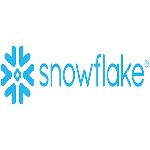

In [14]:

import PIL.Image

bytes_object = session.file.get_stream(
    "@My_Images/101.png.gz", decompress=True)
image = PIL.Image.open(bytes_object)
image.resize((150,150))

##### Dynamically Reading Multiple Files

* This section defines UDF that aids in working with multiple image files at once
* Also provides execution methodology to utilize the UDF to print size of each image file

In [15]:
import snowflake.snowpark as snowpark
from snowflake.snowpark.functions import udf
from snowflake.snowpark.files import SnowflakeFile
from snowflake.snowpark.types import StringType, IntegerType

@udf(
    name="get_bytes_length",
    replace=True,
    input_types=[StringType()],
    return_type=IntegerType(),
    packages=['snowflake-snowpark-python']
)
def get_file_length(file_path):
  with SnowflakeFile.open(file_path, mode = 'rb') as f:
    b = f.read()
    return len(b)



In [16]:
session.sql("""SELECT RELATIVE_PATH, get_bytes_length(build_scoped_file_url(@My_Images,RELATIVE_PATH))
             as SIZE from DIRECTORY(@My_Images);""").collect()

[Row(RELATIVE_PATH='100.png.gz', SIZE=2499),
 Row(RELATIVE_PATH='1007.png.gz', SIZE=2280),
 Row(RELATIVE_PATH='101.png.gz', SIZE=3028)]